In [1]:
import joblib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from truvari.annotations.repmask import RepMask

We're interested in finding TR Regions which have 'contamination' from interspersed repeats. There are known 'tandem ALU' problems introduced by Vamos, but we need to inspect the other annotation sources for potential problems as well. 

To build a system to identify this 'contamination', we'll analyze our v0.3 TR catalog on chr1 and compile a list of suspect regions. If that set of regions has good intersection with the known Vamos problems, we may be able to assume the system is accurately finding contamination problems in the other annotation sources as well.

Methods:
- Run repeat masker over the reference sequence of each region.
- Denote which annotations are 'TR' vs non-TR (a.k.a. interspersed repeats)
  - TR annotations are those which have a class of Simple_repeat, Low_complexity, Satellite, or Unknown.
    - We choose to consider Unknown as TRs because we have some confidence in the original sources to have TRs. So if repeat masker doesn't know, we trust the source.
  - Interspersed repeats reported by RepeatMasker are SINE, LINE, LTR, DNA elements, and Small RNA
- Confident RepeatMasker annotations (generally) have at least a score of 225. Denote which annotations have a high score.
- There may be multiple repeat masker annotations per-region.
- If a region has no TR annotation and any high scoring interspersed repeat annotation, set that region as being suspect.

Not sure if we'll fully remove these regions or just give them an annotation of 'contaminated'. Probably just want to remove them for data simplicity, though.


Results:
How many TR Regions are we looking at?
How many have RepMask TR annotations?
How many have high-scoring interspersed repeat annotations?
How many have no TR annotations AND high-scoring interspersed repeat annotations?

Give that 4th list to Mark. Ask him how well this list agress with his known 'tandem ALUs'.
We want to check if the list has high sensitivity (all the problem tandem ALUs on chromosome 1 are marked).
And a good estimated specificity (Vamos regions which aren't considered 'tandem ALU problems' aren't marked at by this system). 
There we be a number of regions in this list with no intersection with Vamos Regions and we won't be able to "validate". However, I'd like to still summarize them by which original source overlaps with them. Perhaps there can be some informative patterns there.

In [2]:
data = RepMask.parse_output("../data/first.fasta.out")
def data_to_df(data):
    rows = []
    for key in data:
        if not key.startswith("chr1:"):
            continue
        for item in data[key]:
            item['region'] = key
            rows.append(pd.Series(item))
    return pd.DataFrame(rows)
data = data_to_df(data)
data.set_index("RM_query", inplace=True)
joblib.dump(data, "../data/partial_repmask1.jl")

KeyboardInterrupt: 

In [3]:
data = joblib.load("../data/partial_repmask1.jl")

In [25]:
data.head()

,RM_score,RM_pdiv,RM_pdel,RM_pins,RM_qstart,RM_qend,RM_qleft,RM_strand,RM_repeat,RM_clsfam,RM_tstart,RM_tend,RM_tleft,region,class,is_tr
RM_query,,,,,,,,,,,,,,,,
chr1:100002758-100002820,26,17.5,3.2,0.0,1,63,0,C,ALUJO,SINE/Alu,153,159,95,chr1:100002758-100002820,SINE,False
chr1:100003388-100003464,27,15.9,0.0,0.0,30,73,4,+,A-RICH,Low_complexity,1,44,(0),chr1:100003388-100003464,Low_complexity,True
chr1:10000715-10000784,18,14.9,0.0,0.0,23,69,1,C,ALUYA5,SINE/Alu,13,298,252,chr1:10000715-10000784,SINE,False
chr1:100007775-100007866,18,7.3,0.0,3.3,32,62,30,+,(TTA)N,Simple_repeat,1,30,(0),chr1:100007775-100007866,Simple_repeat,True
chr1:100007931-100007996,14,8.1,0.0,0.0,28,64,2,C,ALUYH7,SINE/Alu,16,295,259,chr1:100007931-100007996,SINE,False


In [4]:
print("Total of %d annotations over %d regions" % (len(data), len(data['region'].unique())))

Total of 121026 annotations over 86425 regions


[None, Text(0.5, 1.0, 'RepeatMasker Score Distribution')]

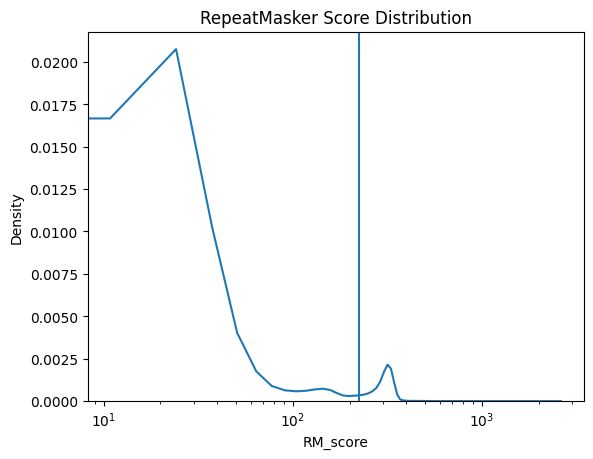

In [109]:
p = sb.kdeplot(data['RM_score'])
p.axvline(225)
p.set(xscale='log', title="RepeatMasker Score Distribution")

In [101]:
print("30 most common repeat class/fams")
cnts = data['RM_clsfam'].value_counts()
cnts = cnts.head(30)
cnts

30 most common repeat class/fams


Simple_repeat        49544
SINE/Alu             49322
LINE/L1               8426
Low_complexity        5784
LTR/ERV1              1622
Retroposon/SVA        1162
LTR/ERVL-MaLR          995
LTR/ERVL               698
LINE/L2                667
DNA/TcMar-Tigger       647
DNA/hAT-Charlie        572
SINE/MIR               482
Unknown                180
srpRNA                 177
Satellite/centr        160
LTR/ERVK               117
DNA/hAT-Tip100         104
Satellite               78
DNA/TcMar-Mariner       63
scRNA                   52
DNA/hAT-Blackjack       27
LINE/CR1                20
DNA/TcMar-Tc2           19
DNA/MULE-MuDR           18
snRNA                   15
Satellite/subtelo       14
LINE/RTE-X              14
DNA/PiggyBac            11
LTR                      9
LTR/Gypsy                8
Name: RM_clsfam, dtype: int64

# Experiment 1

Let's get a list of TR class/fams and extract those NOT in them.

Then, we'll intersect them with all the sources and ask: Do these hit VAMOS more than anything.

Also, we'll try to look at the repeat structures? 

In [5]:
data['class'] = data['RM_clsfam'].apply(lambda x: x.split('/')[0])

In [10]:
data['class'].value_counts()

SINE              49805
Simple_repeat     49544
LINE               9127
Low_complexity     5784
LTR                3449
DNA                1471
Retroposon         1162
Satellite           252
Unknown             180
srpRNA              177
scRNA                52
snRNA                15
tRNA                  5
rRNA                  3
Name: class, dtype: int64

In [24]:

len(data[~data["is_tr"] & (data["RM_score"] >= 225)].index.unique())

9005

In [18]:
tr_clsfams = ["Simple_repeat", "Low_complexity", "Satellite",
              "Satellite/centr", "Satellite/subtelo", "Unknown"]
data['is_tr'] = data["RM_clsfam"].isin(tr_clsfams)


In [19]:
data['is_tr'].value_counts()

False    65266
True     55760
Name: is_tr, dtype: int64

In [114]:
data['high_score'] = data["RM_score"] >= 225

In [115]:
would_keep = data[data['is_tr']] # Annotations we're intersted in keeping
total_regions = len(data['region'].unique()) # Total number of reginos
keep_count = len(would_keep.index.unique()) # Percent of regions with at least one TR annotation

In [116]:
print("Regions with at least one TR annotation from Repeat Masker")
print(keep_count, '/', total_regions, '(', round(keep_count / total_regions * 100, 2), '%)')

Regions with at least one TR annotation from Repeat Masker
49345 / 86425 ( 57.1 %)


In [117]:
#Find the suspects with:
# no TR annotation from repmask
suspect = data[~data.index.isin(would_keep.index)] 
# And and any highscoring non-TR annotation
super_suspect = suspect[~suspect['is_tr']].groupby(['region'])['high_score'].any()
super_suspect = super_suspect[super_suspect].index

In [118]:
import re

x = pd.Series(super_suspect).apply(lambda _: re.split('[:-]', _))
x = pd.DataFrame(x.to_list(), columns=["chrom", "start", "end"])
x.to_csv("suspect.bed", sep='\t', header=False, index=False)

In [119]:
# Summaries
print("How many TR Regions are we looking at?")
print(len(data.index.unique()))
print("How many have RepMask TR annotations?")
print(keep_count)
print("How many have high-scoring interspersed repeat annotations?")
print(len(data[data['high_score'] & ~data['is_tr']].index.unique()))
print("How many have no RepMask TR annotations AND high-scoring interspersed repeat annotations?")
print(len(super_suspect))

How many TR Regions are we looking at?
86425
How many have RepMask TR annotations?
49345
How many have high-scoring interspersed repeat annotations?
9005
How many have no TR annotations AND high-scoring interspersed repeat annotations?
7229


In [155]:
s = pd.read_csv("~/code/truvari/x.txt", sep=' ')

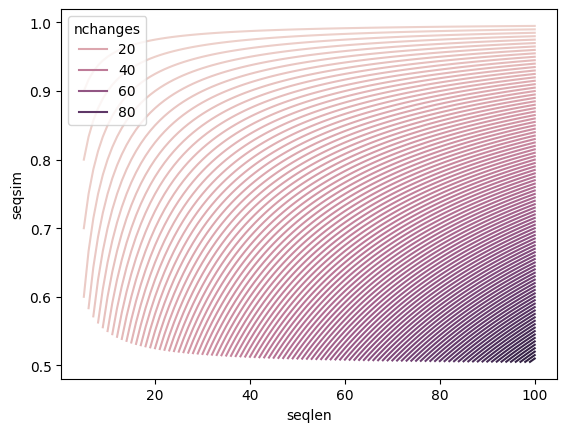

In [161]:

    p = sb.lineplot(data=s, x="seqlen", y="seqsim", hue='nchanges')
    #p = sb.lineplot(data=s, x="seqlen", y="sizesim", hue='nchanges')
#    plt.show()
#p.set(title="Sequence similarity of identical length alleles", ylabel="Num. Changes", xlabel="Sequence Length")

[Text(0.5, 1.0, 'Size similarity of alleles'),
 Text(0, 0.5, 'Num. Changes'),
 Text(0.5, 0, 'Sequence Length')]

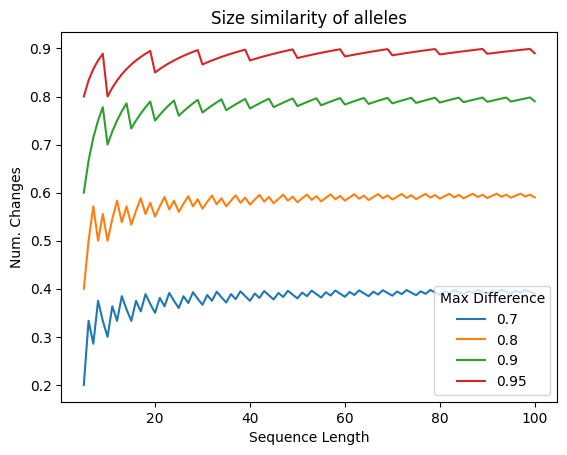

In [152]:
p = sb.lineplot(data=s, x="seqlen", y="sizediff", hue='Max Difference')
p.set(title="Size similarity of alleles", ylabel="SizeDiff", xlabel="Sequence Length")

In [151]:
s[s['seqlen'] < 11]

,thresh,seqlen,nchanges,sizediff,Max Difference
0,0.70,5,3,0.200000,0.7
1,0.70,6,3,0.333333,0.7
2,0.70,7,4,0.285714,0.7
3,0.70,8,4,0.375000,0.7
4,0.70,9,5,0.333333,0.7
5,0.70,10,6,0.300000,0.7
96,0.80,5,2,0.400000,0.8
97,0.80,6,2,0.500000,0.8
98,0.80,7,2,0.571429,0.8
99,0.80,8,3,0.500000,0.8
